In [13]:
# !pip install jupyter-black
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Профилирование ASR на TEDLIUM dev: Whisper vs Wav2Vec2

Этот блокнот реализует полный эксперимент из ТЗ:

- сравнение моделей **Whisper (tiny/base/small/medium)** и **wav2vec2-base-960h**;
- профилирование на dev-сете **TEDLIUM release 3** (обёртка `lmms-lab/tedlium`);
- измерения по осям:
  - длина аудио: ~5 / 15 / 30 / 60 секунд (бакеты),
  - размер батча: 1 / 4 / 8 / 16 / 32,
  - девайс: CPU vs GPU (T4 в Colab),
  - тип декодирования: Whisper `generate()` (AR) vs wav2vec2 `CTC greedy`.
- измеряем:
  - latency, RTF,
  - WER / CER,
  - пик памяти GPU,
  - приближённые FLOPs,
  - приближённое энергопотребление.

Ключевой акцент: разложить время по **этапам** (preproc / encoder / decoder/CTC) и понять, какие части моделей требуют оптимизации по времени и энергии.


In [14]:
import os
import io
import math
import time
import random
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from datasets import load_dataset, Audio

import soundfile as sf
import librosa

from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
)

from jiwer import wer as jiwer_wer, cer as jiwer_cer

from thop import profile as thop_profile
from fvcore.nn import FlopCountAnalysis

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# --- БАЗОВЫЕ НАСТРОЙКИ И ИМЕНА ФАЙЛОВ ---

CSV_FILENAME = "asr_profiling_cpu_only.csv"  # можно менять под CPU/GPU/ALL

BASE_EXPERIMENT_DIR = Path("ASR_Experiments")
BASE_EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

RESULT_CSV_PATH = BASE_EXPERIMENT_DIR / CSV_FILENAME

PLOTS_DIR = BASE_EXPERIMENT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Базовые настройки загружены.")
print("Локальная папка экспериментов:", BASE_EXPERIMENT_DIR.resolve())
print("CSV по умолчанию:", RESULT_CSV_PATH.resolve())
print("Папка для графиков:", PLOTS_DIR.resolve())

PyTorch: 2.9.1
CUDA available: False
Базовые настройки загружены.
Локальная папка экспериментов: /Users/velerene/Documents/itmo/eltb/ASR_Experiments
CSV по умолчанию: /Users/velerene/Documents/itmo/eltb/ASR_Experiments/asr_profiling_cpu_only.csv
Папка для графиков: /Users/velerene/Documents/itmo/eltb/ASR_Experiments/plots


In [15]:
# # --- ПОДКЛЮЧЕНИЕ GOOGLE DRIVE ---

# try:
#     from google.colab import drive

#     print("Похоже, мы в Google Colab. Подключаем Google Drive...")
#     drive.mount("/content/drive")

#     DRIVE_EXPERIMENT_DIR = Path("/content/drive/My Drive/ASR_Experiments")
#     DRIVE_EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

#     BASE_EXPERIMENT_DIR = DRIVE_EXPERIMENT_DIR
#     RESULT_CSV_PATH = BASE_EXPERIMENT_DIR / CSV_FILENAME

#     PLOTS_DIR = BASE_EXPERIMENT_DIR / "plots"
#     PLOTS_DIR.mkdir(parents=True, exist_ok=True)

#     print("Google Drive успешно подключен.")
#     print("Папка экспериментов на диске:", BASE_EXPERIMENT_DIR)
#     print("CSV будет сохранён сюда:", RESULT_CSV_PATH)
#     print("Графики будут сохранены сюда:", PLOTS_DIR)

# except ImportError:
#     print("Вы не в Google Colab, работаем локально.")
# except Exception as e:
#     print(f"Не удалось подключить Google Drive ({e}). Используем локальный путь:")
#     print("CSV:", RESULT_CSV_PATH.resolve())
#     print("Графики:", PLOTS_DIR.resolve())

## Конфигурация эксперимента

Задаём список моделей, бакеты по длительности, размеры батча и приближённые мощности устройств
для оценки энергопотребления.


In [16]:
TARGET_SR = 16000

ASR_MODELS = [
    "openai/whisper-tiny",
    "openai/whisper-base",
    "openai/whisper-small",
    "openai/whisper-medium",
    "openai/whisper-large-v3-turbo",
    "facebook/wav2vec2-base-960h",
]


def get_model_type(model_name: str) -> str:
    if "wav2vec2" in model_name:
        return "ctc"
    else:
        return "whisper"


RUN_ON_CPU = True
RUN_ON_GPU = False

# Batch sizes, которые будут прогоняться (по ТЗ)
BATCH_SIZES = [1, 4, 8, 16, 32]

# Бакеты по длительности (в секундах)
LENGTH_BUCKETS = {
    "5s": (3.0, 7.0),
    "15s": (10.0, 20.0),
    "30s": (25.0, 40.0),
    "60s": (50.0, 75.0),
}
LENGTH_SECONDS = {"5s": 5.0, "15s": 15.0, "30s": 30.0, "60s": 60.0}

# Кол-во батчей на конфигурацию
N_BATCHES_PER_CONFIG = 2

MAX_EXAMPLES_PER_BUCKET = 256

POWER_WATTS = {
    "cpu": 15.0,
    "cuda": 150.0,
}

# Whisper-medium может не влезать на T4 по памяти
# Turbo занимает столько же или чуть больше памяти (~6GB), чем Medium.
# Если будут вылеты (OOM), скрипт их поймает и просто напишет ошибку, не остановившись.
SKIP_WHISPER_MEDIUM_ON_GPU = False

print("Модели:", ASR_MODELS)
print("Batch sizes:", BATCH_SIZES)
print("Length buckets:", LENGTH_BUCKETS)
print("RUN_ON_CPU:", RUN_ON_CPU, "RUN_ON_GPU:", RUN_ON_GPU)

Модели: ['openai/whisper-tiny', 'openai/whisper-base', 'openai/whisper-small', 'openai/whisper-medium', 'openai/whisper-large-v3-turbo', 'facebook/wav2vec2-base-960h']
Batch sizes: [1, 4, 8, 16, 32]
Length buckets: {'5s': (3.0, 7.0), '15s': (10.0, 20.0), '30s': (25.0, 40.0), '60s': (50.0, 75.0)}
RUN_ON_CPU: True RUN_ON_GPU: False


## Загрузка TEDLIUM dev и построение метаданных

Используем `lmms-lab/tedlium` (release 3 dev/test). Для каждого примера считаем длительность,
фильтруем служебные сегменты `ignore_time_segment_in_scoring` и назначаем бакеты по длительности.


In [17]:
# Используем lmms-lab/tedlium: это обёртка над TEDLIUM release 3
# с удобным dev/test-сплитом и полем 'gt' для референсных транскриптов.
DATASET_NAME = "lmms-lab/tedlium"
DATASET_SUBSET = "tedlium_dev_test"
DATASET_SPLIT = "val"

print("Загружаем датасет:", DATASET_NAME, DATASET_SUBSET, DATASET_SPLIT)
raw_ds = load_dataset(DATASET_NAME, DATASET_SUBSET, split=DATASET_SPLIT)

# Отключаем автоматическое декодирование, чтобы не требовался torchcodec
raw_ds = raw_ds.cast_column("audio", Audio(decode=False))

print("Пример полей:", raw_ds[0].keys())
print(
    "Пример audio-словаря:",
    {k: type(v).__name__ for k, v in raw_ds[0]["audio"].items()},
)

IGNORE_TOKEN = "ignore_time_segment_in_scoring"


def get_transcript(example: Dict[str, Any]) -> str:
    """Достаём текст транскрипта из полей gt/text."""
    txt = example.get("gt") or example.get("text") or ""
    return str(txt).strip()


def load_waveform_from_dataset(
    dataset, idx: int, target_sr: int = TARGET_SR
) -> Tuple[np.ndarray, int, float]:
    """Достаём аудио из поля 'audio' через bytes/path, без зависимости от torchcodec."""
    ex = dataset[int(idx)]
    audio_dict = ex["audio"]

    data = None
    sr_orig = None

    if isinstance(audio_dict, dict):
        if "array" in audio_dict and "sampling_rate" in audio_dict:
            # Случай decode=True (на всякий)
            data = audio_dict["array"]
            sr_orig = audio_dict["sampling_rate"]
        elif "bytes" in audio_dict:
            raw_bytes = audio_dict["bytes"]
            data, sr_orig = sf.read(io.BytesIO(raw_bytes))
        elif "path" in audio_dict:
            path = audio_dict["path"]
            data, sr_orig = sf.read(path)
        else:
            raise ValueError(f"Неизвестный формат audio_dict: {audio_dict.keys()}")
    else:
        raise TypeError("Ожидался dict в поле 'audio'")

    if data.ndim > 1:
        # стерео -> моно
        data = np.mean(data, axis=1)

    if sr_orig != target_sr:
        data = librosa.resample(
            data.astype(np.float32), orig_sr=sr_orig, target_sr=target_sr
        )
        sr = target_sr
    else:
        sr = sr_orig
        data = data.astype(np.float32)

    duration = float(len(data)) / float(sr) if sr > 0 else 0.0
    return data, sr, duration


def build_metadata(dataset) -> pd.DataFrame:
    """Строим таблицу с id, текстом, длительностью и базовыми статистиками."""
    rows = []
    for i, ex in enumerate(dataset):
        text = get_transcript(ex)
        if IGNORE_TOKEN in text:
            continue

        try:
            _, sr, dur = load_waveform_from_dataset(dataset, i, target_sr=TARGET_SR)
        except Exception as e:
            print(f"[WARN] Не удалось прочитать аудио idx={i}: {e}")
            continue

        rows.append(
            {
                "id": i,
                "transcript": text,
                "duration_s": dur,
                "num_words": len(text.split()),
                "num_chars": len(text),
            }
        )
    return pd.DataFrame(rows)


df_meta = build_metadata(raw_ds)
print("Всего примеров после фильтрации:", len(df_meta))
print(df_meta["duration_s"].describe())


def assign_length_bucket(duration: float) -> str:
    for name, (lo, hi) in LENGTH_BUCKETS.items():
        if lo <= duration < hi:
            return name
    return "other"


df_meta["length_bucket"] = df_meta["duration_s"].apply(assign_length_bucket)
df_meta = df_meta[df_meta["length_bucket"] != "other"].reset_index(drop=True)

print("Распределение по бакетам длительности:")
print(df_meta["length_bucket"].value_counts())
df_meta.head()

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 5209f139-603a-4809-82a8-f4cbe927e0fb)')' thrown while requesting HEAD https://huggingface.co/datasets/lmms-lab/tedlium/resolve/main/README.md
Retrying in 1s [Retry 1/5].


Загружаем датасет: lmms-lab/tedlium tedlium_dev_test val


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /datasets/lmms-lab/tedlium/resolve/main/README.md (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x3cac5b830>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: cd4345b4-bb99-45f3-9615-b0c0d3679c8e)')' thrown while requesting HEAD https://huggingface.co/datasets/lmms-lab/tedlium/resolve/main/README.md
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /datasets/lmms-lab/tedlium/resolve/main/README.md (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x3cac58680>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: a90a869e-f66f-400c-8597-b1b1d391ba96)')' thrown while requesting HEAD https://huggingface.co/datasets/lmms-lab

Пример полей: dict_keys(['audio', 'gt', 'prompt', 'source', 'task'])
Пример audio-словаря: {'bytes': 'bytes', 'path': 'str'}
Всего примеров после фильтрации: 507
count    507.000000
mean      11.347988
std        5.682475
min        0.470000
25%        7.475000
50%       10.640000
75%       14.355000
max       39.920000
Name: duration_s, dtype: float64
Распределение по бакетам длительности:
length_bucket
15s    243
5s      80
30s     10
Name: count, dtype: int64


,id,transcript,duration_s,num_words,num_chars,length_bucket
0,3,the official dogma of what the official dogma ...,11.85,31,182,15s
1,4,the way to do that is to maximize individual f...,10.38,24,118,15s
2,5,valuable worthwhile essential to being human a...,13.12,39,201,15s
3,6,the way to maximize freedom is to maximize cho...,13.22,30,162,15s
4,7,this i think is so deeply embedded in the wate...,14.16,30,147,15s


## Нормализация текста и метрики WER/CER

Простая нормализация (lowercase, удаление пунктуации) и функции для подсчёта WER/CER для батча.


In [18]:
import re


def normalize_text(s: str) -> str:
    s = s.lower().strip()
    # оставляем буквы/цифры/пробелы/апостроф
    s = re.sub(r"[^a-z0-9\s']+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()


def compute_wer_batch(refs: List[str], hyps: List[str]) -> float:
    refs_norm = [normalize_text(r) for r in refs]
    hyps_norm = [normalize_text(h) for h in hyps]
    return float(jiwer_wer(refs_norm, hyps_norm))


def compute_cer_batch(refs: List[str], hyps: List[str]) -> float:
    refs_norm = [normalize_text(r) for r in refs]
    hyps_norm = [normalize_text(h) for h in hyps]
    return float(jiwer_cer(refs_norm, hyps_norm))

## Загрузка моделей ASR

Определяем dataclass `AsrComponents` и функцию `load_asr_components`, которая
создаёт пару (модель + процессор) на указанном устройстве (CPU или CUDA).


In [19]:
@dataclass
class AsrComponents:
    model_name: str
    model_type: str  # "whisper" или "ctc"
    model: torch.nn.Module
    processor: Any
    device: torch.device


def load_asr_components(model_name: str, device_str: str) -> AsrComponents:
    model_type = get_model_type(model_name)
    device = torch.device(device_str)

    print(f"\n=== Загружаем {model_name} на {device_str} (тип: {model_type}) ===")

    if model_type == "whisper":
        processor = WhisperProcessor.from_pretrained(model_name)
        dtype = (
            torch.float16
            if device_str == "cuda" and torch.cuda.is_available()
            else torch.float32
        )
        model = WhisperForConditionalGeneration.from_pretrained(
            model_name, torch_dtype=dtype
        )
        # Для задач транскрипции на английском принудительно фиксируем язык/задачу
        try:
            model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(
                language="en", task="transcribe"
            )
        except Exception:
            pass

        model.to(device)
        model.eval()
    else:
        processor = Wav2Vec2Processor.from_pretrained(model_name)
        # wav2vec2 в fp32, чтобы не терять качество
        model = Wav2Vec2ForCTC.from_pretrained(model_name)
        model.to(device)
        model.eval()

    if device_str == "cuda" and torch.cuda.is_available():
        print(
            "Device set to use",
            torch.cuda.current_device(),
            torch.cuda.get_device_name(0),
        )

    return AsrComponents(
        model_name=model_name,
        model_type=model_type,
        model=model,
        processor=processor,
        device=device,
    )

## Транскрипция с профилированием этапов

Здесь реализуем:
- вспомогательные функции `_sync_cuda` и `_chunk_long_audio`;
- отдельные реализации с профилированием для Whisper и wav2vec2 (CTC);
- общий entry-point `transcribe_batch_with_profiling` и простой wrapper `transcribe_batch`.

Важно: для Whisper аудио длиннее ~30 сек разбиваем на окна по 30 сек и декодируем по чанкам,
чтобы масштабирование по длине было честным.


In [20]:
def _sync_cuda(device: torch.device) -> None:
    """Синхронизация CUDA для корректного измерения времени."""
    if device.type == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize(device.index if device.index is not None else None)


def _chunk_long_audio(
    wav: np.ndarray,
    sr: int,
    max_len_s: float = 30.0,
) -> List[np.ndarray]:
    """Разбивает аудио на окна max_len_s секунд для Whisper (30-секундное ограничение)."""
    max_samples = int(max_len_s * sr)
    if len(wav) <= max_samples:
        return [wav]

    chunks: List[np.ndarray] = []
    start = 0
    while start < len(wav):
        end = min(start + max_samples, len(wav))
        chunks.append(wav[start:end])
        start = end
    return chunks


def _transcribe_whisper_with_profiling(
    components: AsrComponents,
    wavs: List[np.ndarray],
    sampling_rate: int,
) -> Tuple[List[str], Dict[str, float]]:
    """Whisper: batched препроцессинг + encoder + decoder(generate) с профилированием.

    ВАЖНО:
    - Whisper в HF ожидает фиксированную длину 3000 мел-фреймов (≈30 сек).
    - Для аудио >30 сек мы разбиваем сигнал на окна по 30 сек и обрабатываем
      их как отдельные "чанки", после чего конкатенируем тексты.
    """
    model: WhisperForConditionalGeneration = components.model
    processor: WhisperProcessor = components.processor
    device = components.device

    if len(wavs) == 0:
        return [], {"t_preproc_s": 0.0, "t_encoder_s": 0.0, "t_decoder_s": 0.0}

    # 1) Чанким аудио на окна 30 сек (если нужно)
    all_chunks: List[np.ndarray] = []
    owners: List[int] = []  # какой исходный utt соответствует чанку

    for i, wav in enumerate(wavs):
        chunks_i = _chunk_long_audio(wav, sr=sampling_rate, max_len_s=30.0)
        for ch in chunks_i:
            all_chunks.append(ch)
            owners.append(i)

    assert len(all_chunks) == len(owners)

    # 2) Препроцессинг (лог-мелы)
    t0 = time.perf_counter()
    inputs = processor(
        all_chunks,
        sampling_rate=sampling_rate,
        return_tensors="pt",
        padding="max_length",  # всегда до 3000 фреймов
        truncation=True,
    )
    input_features = inputs.input_features.to(device=device, dtype=model.dtype)
    _sync_cuda(device)
    t1 = time.perf_counter()
    t_preproc = t1 - t0

    # 3) Encoder
    with torch.no_grad():
        _sync_cuda(device)
        t0 = time.perf_counter()
        encoder_outputs = model.model.encoder(input_features)
        _sync_cuda(device)
        t1 = time.perf_counter()
    t_encoder = t1 - t0

    # 4) Decoder (generate) — используем заранее посчитанный encoder_outputs
    with torch.no_grad():
        _sync_cuda(device)
        t0 = time.perf_counter()
        generated_ids = model.generate(encoder_outputs=encoder_outputs)
        _sync_cuda(device)
        t1 = time.perf_counter()
    t_decoder = t1 - t0

    chunk_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    chunk_texts = [t.strip() for t in chunk_texts]

    # 5) Склеиваем чанки обратно в utterances
    final_texts: List[str] = ["" for _ in wavs]
    for txt, owner in zip(chunk_texts, owners):
        if final_texts[owner]:
            final_texts[owner] += " " + txt
        else:
            final_texts[owner] = txt

    timing = {
        "t_preproc_s": float(t_preproc),
        "t_encoder_s": float(t_encoder),
        "t_decoder_s": float(t_decoder),
    }
    return final_texts, timing


def _transcribe_ctc_with_profiling(
    components: AsrComponents,
    wavs: List[np.ndarray],
    sampling_rate: int,
) -> Tuple[List[str], Dict[str, float]]:
    """Wav2Vec2 CTC: препроцессинг + encoder(+head) + CTC-decode (argmax) с профилированием."""
    model: Wav2Vec2ForCTC = components.model
    processor: Wav2Vec2Processor = components.processor
    device = components.device

    if len(wavs) == 0:
        return [], {"t_preproc_s": 0.0, "t_encoder_s": 0.0, "t_decoder_s": 0.0}

    # 1) Препроцессинг
    t0 = time.perf_counter()
    inputs = processor(
        wavs,
        sampling_rate=sampling_rate,
        return_tensors="pt",
        padding=True,
    )
    input_values = inputs.input_values.to(device)
    attention_mask = (
        inputs.attention_mask.to(device) if hasattr(inputs, "attention_mask") else None
    )
    _sync_cuda(device)
    t1 = time.perf_counter()
    t_preproc = t1 - t0

    # 2) Encoder + CTC head (логиты)
    with torch.no_grad():
        _sync_cuda(device)
        t0 = time.perf_counter()
        logits = model(input_values, attention_mask=attention_mask).logits
        _sync_cuda(device)
        t1 = time.perf_counter()
    t_encoder = t1 - t0

    # 3) Greedy CTC decode (argmax + tokenizer)
    t0 = time.perf_counter()
    pred_ids = torch.argmax(logits, dim=-1)
    texts = processor.batch_decode(pred_ids)
    texts = [t.strip() for t in texts]
    t1 = time.perf_counter()
    t_decoder = t1 - t0

    timing = {
        "t_preproc_s": float(t_preproc),
        "t_encoder_s": float(t_encoder),
        "t_decoder_s": float(t_decoder),
    }
    return texts, timing


def transcribe_batch_with_profiling(
    components: AsrComponents,
    wavs: List[np.ndarray],
    sampling_rate: int = TARGET_SR,
) -> Tuple[List[str], Dict[str, float]]:
    """Общий entry-point для батчевой транскрипции с профилированием этапов."""
    if components.model_type == "whisper":
        return _transcribe_whisper_with_profiling(components, wavs, sampling_rate)
    else:
        return _transcribe_ctc_with_profiling(components, wavs, sampling_rate)


def transcribe_batch(
    components: AsrComponents,
    wavs: List[np.ndarray],
    sampling_rate: int = TARGET_SR,
) -> List[str]:
    """Простой wrapper без возвращения таймингов (для интерактивного использования)."""
    texts, _ = transcribe_batch_with_profiling(
        components=components,
        wavs=wavs,
        sampling_rate=sampling_rate,
    )
    return texts

## Приближённая оценка FLOPs

Для Whisper считаем FLOPs encoder'а и одного шага decoder'а через `thop_profile`,
для wav2vec2 используем `FlopCountAnalysis`. Затем получаем скаляр `gflops_per_example`.


In [21]:
def estimate_whisper_flops(
    model: WhisperForConditionalGeneration,
    processor: WhisperProcessor,
    length_s: float,
    device: torch.device,
) -> Tuple[float, float]:
    """Возвращает (encoder_GFLOPs, decoder_step_GFLOPs) для одного примера длиной length_s."""
    # dummy-аудио нужной длины
    dummy_audio = torch.randn(int(length_s * TARGET_SR), dtype=torch.float32)

    inputs = processor(
        dummy_audio,
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
    )
    input_features = inputs.input_features.to(device=device, dtype=model.dtype)

    # ENCODER FLOPs
    macs_enc, _ = thop_profile(
        model.model.encoder,
        inputs=(input_features,),
        verbose=False,
    )
    enc_gflops = macs_enc * 2.0 / 1e9

    # DECODER (один шаг) FLOPs
    with torch.no_grad():
        encoder_outputs = model.model.encoder(input_features)

    class DecoderStepWrapper(torch.nn.Module):
        def __init__(self, wrapped_model: WhisperForConditionalGeneration):
            super().__init__()
            self.wrapped_model = wrapped_model

        def forward(self, decoder_input_ids, encoder_hidden_states):
            return self.wrapped_model.model.decoder(
                input_ids=decoder_input_ids,
                encoder_hidden_states=encoder_hidden_states,
            )

    decoder_input_ids = (
        torch.ones(
            (1, 1),
            dtype=torch.long,
            device=device,
        )
        * model.config.decoder_start_token_id
    )

    dec_wrapper = DecoderStepWrapper(model).to(device)

    macs_dec, _ = thop_profile(
        dec_wrapper,
        inputs=(decoder_input_ids, encoder_outputs.last_hidden_state),
        verbose=False,
    )
    dec_gflops = macs_dec * 2.0 / 1e9

    return float(enc_gflops), float(dec_gflops)


def estimate_wav2vec2_flops(
    model: Wav2Vec2ForCTC,
    processor: Wav2Vec2Processor,
    length_s: float,
    device: torch.device,
) -> float:
    """Грубая оценка FLOPs для wav2vec2 на одном примере длиной length_s."""
    dummy_audio = torch.randn(int(length_s * TARGET_SR), dtype=torch.float32)
    inputs = processor(dummy_audio, sampling_rate=TARGET_SR, return_tensors="pt")
    input_values = inputs.input_values.to(device)

    try:
        fca = FlopCountAnalysis(model, input_values)
        flops_total = fca.total()
        gflops = flops_total / 1e9
        return float(gflops)
    except Exception as e:
        print(f"[WARN] FlopCountAnalysis не сработал для wav2vec2: {e}")
        return float("nan")


def estimate_gflops_per_example(
    components: AsrComponents,
    length_bucket: str,
) -> float:
    """Скалярная приблизительная оценка FLOPs на пример."""
    length_s = LENGTH_SECONDS[length_bucket]
    device = components.device
    model = components.model
    processor = components.processor

    try:
        if components.model_type == "whisper":
            enc_g, dec_step_g = estimate_whisper_flops(
                model, processor, length_s, device
            )
            # Грубая оценка числа токенов на секунду
            tokens_per_second = 3.0
            approx_tokens = max(int(tokens_per_second * length_s), 1)
            total_gflops = enc_g + dec_step_g * approx_tokens
            return float(total_gflops)
        else:
            return estimate_wav2vec2_flops(model, processor, length_s, device)
    except RuntimeError as e:
        print(f"[WARN] Не удалось посчитать FLOPs (RuntimeError): {e}")
        return float("nan")
    except Exception as e:
        print(f"[WARN] Не удалось посчитать FLOPs: {e}")
        return float("nan")

## Профилирование одной конфигурации

Описываем структуру `ProfilingConfig`, выбор примеров для бакета и функцию
`run_profiling_for_config`, которая прогоняет несколько батчей и собирает метрики
по latency/RTF/WER/CER/энергии/FLOPs и по этапам (preproc/encoder/decoder).


In [22]:
@dataclass
class ProfilingConfig:
    model_name: str
    model_type: str
    decode_type: str
    device_type: str
    length_bucket: str
    batch_size: int
    n_batches: int = N_BATCHES_PER_CONFIG


def sample_indices_for_bucket(
    df: pd.DataFrame,
    bucket_name: str,
    batch_size: int,
    n_batches: int,
) -> List[List[int]]:
    """Случайно выбираем id-шники для нужного бакета и разбиваем на батчи."""
    df_bucket = df[df["length_bucket"] == bucket_name].copy()
    if df_bucket.empty:
        return []

    max_utts = batch_size * n_batches
    df_bucket = df_bucket.sample(
        n=min(len(df_bucket), max_utts, MAX_EXAMPLES_PER_BUCKET),
        random_state=SEED,
    )

    ids = df_bucket["id"].tolist()
    batches = [ids[i : i + batch_size] for i in range(0, len(ids), batch_size)]
    return batches[:n_batches]


def run_profiling_for_config(
    config: ProfilingConfig,
    df_meta: pd.DataFrame,
    dataset,
    components: AsrComponents,
) -> List[Dict[str, Any]]:
    batches = sample_indices_for_bucket(
        df=df_meta,
        bucket_name=config.length_bucket,
        batch_size=config.batch_size,
        n_batches=config.n_batches,
    )

    if len(batches) == 0:
        print(
            f"[{config.model_name} | {config.device_type} | {config.length_bucket} | bsz={config.batch_size}] нет примеров, пропускаем."
        )
        return []

    print(
        f"""\n=== Профилирование: {config.model_name}, device={config.device_type},
length_bucket={config.length_bucket}, batch_size={config.batch_size}, decode={config.decode_type} ==="""
    )
    print("Всего батчей:", len(batches))

    # Оценка FLOPs (одна на конфигурацию)
    gflops_per_example = estimate_gflops_per_example(components, config.length_bucket)

    results: List[Dict[str, Any]] = []

    if components.device.type == "cuda" and torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(components.device)

    total_utts_config = 0
    total_audio_duration_config = 0.0

    total_t_preproc_s = 0.0
    total_t_encoder_s = 0.0
    total_t_decoder_s = 0.0

    t_config_start = time.perf_counter()

    for batch_idx, batch_ids in enumerate(batches, start=1):
        wavs = []
        refs = []
        durations = []

        for idx in batch_ids:
            wav, sr, dur = load_waveform_from_dataset(dataset, idx, target_sr=TARGET_SR)
            wavs.append(wav)
            durations.append(dur)

            ref = df_meta.loc[df_meta["id"] == idx, "transcript"].values[0]
            refs.append(ref)

        batch_audio_sec = float(sum(durations))
        total_utts_config += len(batch_ids)
        total_audio_duration_config += batch_audio_sec

        t_batch_start = time.perf_counter()
        hyps, timing = transcribe_batch_with_profiling(
            components,
            wavs,
            sampling_rate=TARGET_SR,
        )
        t_batch_end = time.perf_counter()

        elapsed = t_batch_end - t_batch_start
        latency_per_utt = elapsed / len(batch_ids)
        rtf = elapsed / batch_audio_sec if batch_audio_sec > 0 else float("nan")

        t_preproc_s = float(timing.get("t_preproc_s", float("nan")))
        t_encoder_s = float(timing.get("t_encoder_s", float("nan")))
        t_decoder_s = float(timing.get("t_decoder_s", float("nan")))

        if not math.isnan(t_preproc_s):
            total_t_preproc_s += t_preproc_s
        if not math.isnan(t_encoder_s):
            total_t_encoder_s += t_encoder_s
        if not math.isnan(t_decoder_s):
            total_t_decoder_s += t_decoder_s

        try:
            batch_wer = compute_wer_batch(refs, hyps)
            batch_cer = compute_cer_batch(refs, hyps)
        except Exception as e:
            print(f"[WARN] Ошибка при подсчёте WER/CER: {e}")
            batch_wer = float("nan")
            batch_cer = float("nan")

        res = {
            "model_name": config.model_name,
            "model_type": config.model_type,
            "decode_type": config.decode_type,
            "device_type": config.device_type,
            "length_bucket": config.length_bucket,
            "batch_size": config.batch_size,
            "batch_index": batch_idx,
            "n_utts": len(batch_ids),
            "total_audio_duration_s": batch_audio_sec,
            "elapsed_s": elapsed,
            "latency_ms_per_utt": latency_per_utt * 1000.0,
            "rtf": rtf,
            "wer": batch_wer,
            "cer": batch_cer,
            "t_preproc_s_batch": t_preproc_s,
            "t_encoder_s_batch": t_encoder_s,
            "t_decoder_s_batch": t_decoder_s,
        }

        results.append(res)

        print(
            f"Батч {batch_idx}/{len(batches)}: elapsed={elapsed:.2f}s, "
            f"rtf={rtf:.2f}, latency/utt={latency_per_utt:.2f}s, WER={batch_wer:.3f}"
        )

    t_config_end = time.perf_counter()
    wallclock_config = t_config_end - t_config_start

    # Энергия и память (статическая модель мощности)
    power_w = POWER_WATTS.get(components.device.type, 100.0)
    energy_j_total = power_w * wallclock_config

    energy_j_per_utt = (
        energy_j_total / total_utts_config if total_utts_config > 0 else float("nan")
    )
    energy_j_per_audio_sec = (
        energy_j_total / total_audio_duration_config
        if total_audio_duration_config > 0
        else float("nan")
    )

    if components.device.type == "cuda" and torch.cuda.is_available():
        max_gpu_mem_bytes = int(torch.cuda.max_memory_allocated(components.device))
    else:
        max_gpu_mem_bytes = 0

    # Среднее время этапов на уттер (по всей конфигурации)
    if total_utts_config > 0:
        t_preproc_ms_per_utt = (total_t_preproc_s / total_utts_config) * 1000.0
        t_encoder_ms_per_utt = (total_t_encoder_s / total_utts_config) * 1000.0
        t_decoder_ms_per_utt = (total_t_decoder_s / total_utts_config) * 1000.0
    else:
        t_preproc_ms_per_utt = float("nan")
        t_encoder_ms_per_utt = float("nan")
        t_decoder_ms_per_utt = float("nan")

    for r in results:
        r["wallclock_s_config"] = wallclock_config
        r["total_utts_config"] = total_utts_config
        r["total_audio_duration_config_s"] = total_audio_duration_config

        r["energy_joules_total_config"] = energy_j_total
        r["energy_j_per_utt"] = energy_j_per_utt
        r["energy_j_per_audio_sec"] = energy_j_per_audio_sec

        r["max_gpu_mem_bytes"] = max_gpu_mem_bytes
        r["gflops_per_example"] = gflops_per_example

        r["total_t_preproc_s_config"] = total_t_preproc_s
        r["total_t_encoder_s_config"] = total_t_encoder_s
        r["total_t_decoder_s_config"] = total_t_decoder_s

        r["t_preproc_ms_per_utt_config"] = t_preproc_ms_per_utt
        r["t_encoder_ms_per_utt_config"] = t_encoder_ms_per_utt
        r["t_decoder_ms_per_utt_config"] = t_decoder_ms_per_utt

    print(
        f"ИТОГО конфигурация: wallclock={wallclock_config:.2f}s, energy_total≈{energy_j_total:.1f} J, "
        f"уттеров={total_utts_config}, аудио_сек={total_audio_duration_config:.1f}"
    )

    return results

## Запуск сетки экспериментов

Перебираем устройства (CPU/GPU), модели, бакеты по длительности и batch size,
запускаем профилирование и складываем результаты в `df_results`.


In [23]:
DEVICES = []
if RUN_ON_CPU:
    DEVICES.append("cpu")
if RUN_ON_GPU and torch.cuda.is_available():
    DEVICES.append("cuda")
if not DEVICES:
    DEVICES = ["cpu"]

print("Будем запускать конфигурации на девайсах:", DEVICES)
print("Batch sizes:", BATCH_SIZES)
print("Length buckets:", list(LENGTH_BUCKETS.keys()))

all_results: List[Dict[str, Any]] = []

for device_str in DEVICES:
    for model_name in ASR_MODELS:
        model_type = get_model_type(model_name)
        decode_type = "generate" if model_type == "whisper" else "ctc_greedy"

        if (
            model_name == "openai/whisper-medium"
            and device_str == "cuda"
            and SKIP_WHISPER_MEDIUM_ON_GPU
        ):
            print(
                "\n[INFO] Пропускаем openai/whisper-medium на GPU, чтобы избежать OOM."
            )
            continue

        components = load_asr_components(model_name, device_str)

        for length_bucket in LENGTH_BUCKETS.keys():
            for bsz in BATCH_SIZES:
                cfg = ProfilingConfig(
                    model_name=model_name,
                    model_type=model_type,
                    decode_type=decode_type,
                    device_type=device_str,
                    length_bucket=length_bucket,
                    batch_size=bsz,
                )
                try:
                    res_cfg = run_profiling_for_config(
                        config=cfg,
                        df_meta=df_meta,
                        dataset=raw_ds,
                        components=components,
                    )
                    all_results.extend(res_cfg)
                except RuntimeError as e:
                    print(
                        f"Конфигурация упала с ошибкой RuntimeError (возможно OOM): {e}"
                    )
                except Exception as e:
                    print(f"Конфигурация упала с ошибкой: {e}")

        # чистим память после модели
        del components
        if device_str == "cuda" and torch.cuda.is_available():
            torch.cuda.empty_cache()

df_results = pd.DataFrame(all_results)
print("\nРазмер таблицы результатов:", df_results.shape)
df_results.head()

Будем запускать конфигурации на девайсах: ['cpu']
Batch sizes: [1, 4, 8, 16, 32]
Length buckets: ['5s', '15s', '30s', '60s']

=== Загружаем openai/whisper-tiny на cpu (тип: whisper) ===

=== Профилирование: openai/whisper-tiny, device=cpu,
length_bucket=5s, batch_size=1, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=0.28s, rtf=0.06, latency/utt=0.28s, WER=0.056
Батч 2/2: elapsed=0.26s, rtf=0.04, latency/utt=0.26s, WER=0.280
ИТОГО конфигурация: wallclock=0.55s, energy_total≈8.2 J, уттеров=2, аудио_сек=11.6

=== Профилирование: openai/whisper-tiny, device=cpu,
length_bucket=5s, batch_size=4, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=0.73s, rtf=0.04, latency/utt=0.18s, WER=0.229
Батч 2/2: elapsed=0.69s, rtf=0.03, latency/utt=0.17s, WER=0.255
ИТОГО конфигурация: wallclock=1.47s, energy_total≈22.0 J, уттеров=8, аудио_сек=39.2

=== Профилирование: openai/whisper-tiny, device=cpu,
length_bucket=5s, batch_size=8, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=1.07s, 

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]


=== Профилирование: openai/whisper-large-v3-turbo, device=cpu,
length_bucket=5s, batch_size=1, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=2.44s, rtf=0.51, latency/utt=2.44s, WER=0.000
Батч 2/2: elapsed=2.82s, rtf=0.42, latency/utt=2.82s, WER=0.280
ИТОГО конфигурация: wallclock=5.28s, energy_total≈79.2 J, уттеров=2, аудио_сек=11.6

=== Профилирование: openai/whisper-large-v3-turbo, device=cpu,
length_bucket=5s, batch_size=4, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=9.91s, rtf=0.51, latency/utt=2.48s, WER=0.271
Батч 2/2: elapsed=9.89s, rtf=0.50, latency/utt=2.47s, WER=0.218
ИТОГО конфигурация: wallclock=19.83s, energy_total≈297.5 J, уттеров=8, аудио_сек=39.2

=== Профилирование: openai/whisper-large-v3-turbo, device=cpu,
length_bucket=5s, batch_size=8, decode=generate ===
Всего батчей: 2
Батч 1/2: elapsed=18.84s, rtf=0.48, latency/utt=2.36s, WER=0.248
Батч 2/2: elapsed=18.71s, rtf=0.47, latency/utt=2.34s, WER=0.170
ИТОГО конфигурация: wallclock=37.61s, energy_tot

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=5s, batch_size=1, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=0.11s, rtf=0.02, latency/utt=0.11s, WER=0.111
Батч 2/2: elapsed=0.16s, rtf=0.02, latency/utt=0.16s, WER=0.320
ИТОГО конфигурация: wallclock=0.28s, energy_total≈4.1 J, уттеров=2, аудио_сек=11.6

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=5s, batch_size=4, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=0.69s, rtf=0.04, latency/utt=0.17s, WER=0.300
Батч 2/2: elapsed=0.59s, rtf=0.03, latency/utt=0.15s, WER=0.418
ИТОГО конфигурация: wallclock=1.31s, energy_total≈19.7 J, уттеров=8, аудио_сек=39.2

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=5s, batch_size=8, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=1.16s, rtf=0.03, latency/utt=0.15s, WER=0.360
Батч 2/2: elapsed=1.11s, rtf=0.03, latency/utt=0.14s, WER=0.348
ИТОГО конфигурация: wallclock=2.34s, energy_total≈35.0 J, уттеров=16, аудио_сек=79.2

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=5s, batch_size=16, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=2.94s, rtf=0.04, latency/utt=0.18s, WER=0.367
Батч 2/2: elapsed=2.97s, rtf=0.04, latency/utt=0.19s, WER=0.230
ИТОГО конфигурация: wallclock=6.04s, energy_total≈90.6 J, уттеров=32, аудио_сек=161.4

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=5s, batch_size=32, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=5.86s, rtf=0.04, latency/utt=0.18s, WER=0.298
Батч 2/2: elapsed=5.92s, rtf=0.03, latency/utt=0.18s, WER=0.200
ИТОГО конфигурация: wallclock=12.04s, energy_total≈180.6 J, уттеров=64, аудио_сек=342.1

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=15s, batch_size=1, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=0.25s, rtf=0.02, latency/utt=0.25s, WER=0.214
Батч 2/2: elapsed=0.23s, rtf=0.02, latency/utt=0.23s, WER=0.206
ИТОГО конфигурация: wallclock=0.50s, energy_total≈7.5 J, уттеров=2, аудио_сек=22.5

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=15s, batch_size=4, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=1.40s, rtf=0.03, latency/utt=0.35s, WER=0.191
Батч 2/2: elapsed=1.55s, rtf=0.02, latency/utt=0.39s, WER=0.207
ИТОГО конфигурация: wallclock=3.04s, energy_total≈45.6 J, уттеров=8, аудио_сек=112.0

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=15s, batch_size=8, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=2.87s, rtf=0.03, latency/utt=0.36s, WER=0.197
Батч 2/2: elapsed=3.22s, rtf=0.03, latency/utt=0.40s, WER=0.206
ИТОГО конфигурация: wallclock=6.27s, energy_total≈94.0 J, уттеров=16, аудио_сек=228.0

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=15s, batch_size=16, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=8.65s, rtf=0.04, latency/utt=0.54s, WER=0.206
Батч 2/2: elapsed=8.01s, rtf=0.04, latency/utt=0.50s, WER=0.193
ИТОГО конфигурация: wallclock=16.99s, energy_total≈254.9 J, уттеров=32, аудио_сек=431.5

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=15s, batch_size=32, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=17.77s, rtf=0.04, latency/utt=0.56s, WER=0.201
Батч 2/2: elapsed=17.49s, rtf=0.04, latency/utt=0.55s, WER=0.178
ИТОГО конфигурация: wallclock=35.93s, energy_total≈538.9 J, уттеров=64, аудио_сек=869.3

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=30s, batch_size=1, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=0.61s, rtf=0.02, latency/utt=0.61s, WER=0.188
Батч 2/2: elapsed=0.58s, rtf=0.02, latency/utt=0.58s, WER=0.212
ИТОГО конфигурация: wallclock=1.24s, energy_total≈18.6 J, уттеров=2, аудио_сек=55.0

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=30s, batch_size=4, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=3.60s, rtf=0.03, latency/utt=0.90s, WER=0.167
Батч 2/2: elapsed=2.61s, rtf=0.02, latency/utt=0.65s, WER=0.154
ИТОГО конфигурация: wallclock=6.40s, energy_total≈96.1 J, уттеров=8, аудио_сек=243.2

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=30s, batch_size=8, decode=ctc_greedy ===
Всего батчей: 2


Батч 1/2: elapsed=7.10s, rtf=0.03, latency/utt=0.89s, WER=0.164
Батч 2/2: elapsed=1.31s, rtf=0.03, latency/utt=0.65s, WER=0.170
ИТОГО конфигурация: wallclock=8.64s, energy_total≈129.5 J, уттеров=10, аудио_сек=295.1

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=30s, batch_size=16, decode=ctc_greedy ===
Всего батчей: 1


Батч 1/1: elapsed=8.59s, rtf=0.03, latency/utt=0.86s, WER=0.165
ИТОГО конфигурация: wallclock=8.82s, energy_total≈132.3 J, уттеров=10, аудио_сек=295.1

=== Профилирование: facebook/wav2vec2-base-960h, device=cpu,
length_bucket=30s, batch_size=32, decode=ctc_greedy ===
Всего батчей: 1


Батч 1/1: elapsed=8.56s, rtf=0.03, latency/utt=0.86s, WER=0.165
ИТОГО конфигурация: wallclock=8.79s, energy_total≈131.8 J, уттеров=10, аудио_сек=295.1
[facebook/wav2vec2-base-960h | cpu | 60s | bsz=1] нет примеров, пропускаем.
[facebook/wav2vec2-base-960h | cpu | 60s | bsz=4] нет примеров, пропускаем.
[facebook/wav2vec2-base-960h | cpu | 60s | bsz=8] нет примеров, пропускаем.
[facebook/wav2vec2-base-960h | cpu | 60s | bsz=16] нет примеров, пропускаем.
[facebook/wav2vec2-base-960h | cpu | 60s | bsz=32] нет примеров, пропускаем.

Размер таблицы результатов: (168, 31)


,model_name,model_type,decode_type,device_type,length_bucket,batch_size,batch_index,n_utts,total_audio_duration_s,elapsed_s,...,energy_j_per_utt,energy_j_per_audio_sec,max_gpu_mem_bytes,gflops_per_example,total_t_preproc_s_config,total_t_encoder_s_config,total_t_decoder_s_config,t_preproc_ms_per_utt_config,t_encoder_ms_per_utt_config,t_decoder_ms_per_utt_config
0,openai/whisper-tiny,whisper,generate,cpu,5s,1,1,1,4.82,0.276283,...,4.093344,0.706358,0,76.487685,0.017522,0.176915,0.337021,8.760958,88.457438,168.510270
1,openai/whisper-tiny,whisper,generate,cpu,5s,1,2,1,6.77,0.256850,...,4.093344,0.706358,0,76.487685,0.017522,0.176915,0.337021,8.760958,88.457438,168.510270
2,openai/whisper-tiny,whisper,generate,cpu,5s,4,1,4,19.28,0.732899,...,2.753483,0.562222,0,76.487685,0.025485,0.598202,0.801915,3.185610,74.775219,100.239339
3,openai/whisper-tiny,whisper,generate,cpu,5s,4,2,4,19.90,0.693903,...,2.753483,0.562222,0,76.487685,0.025485,0.598202,0.801915,3.185610,74.775219,100.239339
4,openai/whisper-tiny,whisper,generate,cpu,5s,8,1,8,39.18,1.068742,...,2.016773,0.407635,0,76.487685,0.045816,1.004703,1.008043,2.863505,62.793935,63.002680


## Агрегация результатов по конфигурациям

Сохраняем сырые результаты в CSV и агрегируем по (модель, тип декодера, девайс, длина, batch size).
Добавляем `length_sec` и удобную подпись `model_decode`.


In [24]:
import os

# Сохранение результатов
if "df_results" in locals() and not df_results.empty:
    df_results.to_csv(RESULT_CSV_PATH, index=False)
    print(f"✅ Результаты сохранены в: {RESULT_CSV_PATH}")
else:
    print("ℹ️ Нет новых результатов в памяти для сохранения.")

✅ Результаты сохранены в: ASR_Experiments/asr_profiling_cpu_only.csv


In [25]:
# Функция агрегации
def aggregate_results(df: pd.DataFrame) -> pd.DataFrame:
    group_cols = [
        "model_name",
        "model_type",
        "decode_type",
        "device_type",
        "length_bucket",
        "batch_size",
    ]

    agg = (
        df.groupby(group_cols)
        .agg(
            n_batches=("batch_index", "nunique"),
            n_utts=("n_utts", "sum"),
            total_audio_duration_s=("total_audio_duration_s", "sum"),
            mean_latency_ms_per_utt=("latency_ms_per_utt", "mean"),
            mean_rtf=("rtf", "mean"),
            mean_wer=("wer", "mean"),
            mean_cer=("cer", "mean"),
            wallclock_s_config=("wallclock_s_config", "max"),
            energy_joules_total_config=("energy_joules_total_config", "max"),
            energy_j_per_utt=("energy_j_per_utt", "max"),
            energy_j_per_audio_sec=("energy_j_per_audio_sec", "max"),
            max_gpu_mem_bytes=("max_gpu_mem_bytes", "max"),
            gflops_per_example=("gflops_per_example", "mean"),
            total_t_preproc_s_config=("total_t_preproc_s_config", "max"),
            total_t_encoder_s_config=("total_t_encoder_s_config", "max"),
            total_t_decoder_s_config=("total_t_decoder_s_config", "max"),
            t_preproc_ms_per_utt=("t_preproc_ms_per_utt_config", "max"),
            t_encoder_ms_per_utt=("t_encoder_ms_per_utt_config", "max"),
            t_decoder_ms_per_utt=("t_decoder_ms_per_utt_config", "max"),
        )
        .reset_index()
    )

    length_to_sec = {"5s": 5.0, "15s": 15.0, "30s": 30.0, "60s": 60.0}
    agg["length_sec"] = agg["length_bucket"].map(length_to_sec)

    # Вспомогательное поле для удобной подписи на графиках
    agg["model_decode"] = agg["model_name"] + " / " + agg["decode_type"]
    return agg

In [26]:
# Загрузка данных (если новая сессия)
# Если df_results нет в памяти, ищем файл по пути RESULT_CSV_PATH
if "df_results" not in locals():
    if os.path.exists(RESULT_CSV_PATH):
        print(f"Загружаем данные из: {RESULT_CSV_PATH}")
        df_results = pd.read_csv(RESULT_CSV_PATH)
        print(f"Загружено {len(df_results)} строк.")
    else:
        # Если на диске файла нет, проверяем локально
        if RESULT_CSV_PATH != CSV_FILENAME and os.path.exists(CSV_FILENAME):
            print(
                f"По пути {RESULT_CSV_PATH} пусто, но найден локальный файл {CSV_FILENAME}. Загружаю его."
            )
            df_results = pd.read_csv(CSV_FILENAME)
        else:
            raise RuntimeError(
                f"Файл не найден ни по пути {RESULT_CSV_PATH}, ни локально! Сначала запустите эксперименты."
            )
else:
    print("ℹДанные уже в памяти.")

ℹДанные уже в памяти.


In [27]:
# Создание таблицы для графиков
if "df_results" in locals() and not df_results.empty:
    df_agg = aggregate_results(df_results)
    print("Агрегация завершена.")
    print("Размер таблицы для графиков (df_agg):", df_agg.shape)

    # Показываем пример данных
    from IPython.display import display

    display(df_agg.head())
else:
    print("⚠️ Нет данных для агрегации.")

Агрегация завершена.
Размер таблицы для графиков (df_agg): (90, 27)


,model_name,model_type,decode_type,device_type,length_bucket,batch_size,n_batches,n_utts,total_audio_duration_s,mean_latency_ms_per_utt,...,max_gpu_mem_bytes,gflops_per_example,total_t_preproc_s_config,total_t_encoder_s_config,total_t_decoder_s_config,t_preproc_ms_per_utt,t_encoder_ms_per_utt,t_decoder_ms_per_utt,length_sec,model_decode
0,facebook/wav2vec2-base-960h,ctc,ctc_greedy,cpu,15s,1,2,2,22.479937,239.084417,...,0,104.475275,0.001017,0.476159,0.000952,0.508416,238.079417,0.476125,15.0,facebook/wav2vec2-base-960h / ctc_greedy
1,facebook/wav2vec2-base-960h,ctc,ctc_greedy,cpu,15s,4,2,8,111.979938,369.091797,...,0,104.475275,0.002924,2.945474,0.004286,0.365505,368.184287,0.535786,15.0,facebook/wav2vec2-base-960h / ctc_greedy
2,facebook/wav2vec2-base-960h,ctc,ctc_greedy,cpu,15s,8,2,16,228.029938,380.784880,...,0,104.475275,0.006541,6.075883,0.008587,0.408828,379.742656,0.536688,15.0,facebook/wav2vec2-base-960h / ctc_greedy
3,facebook/wav2vec2-base-960h,ctc,ctc_greedy,cpu,15s,16,2,32,431.489937,520.609876,...,0,104.475275,0.014495,16.626918,0.016096,0.452957,519.591195,0.502992,15.0,facebook/wav2vec2-base-960h / ctc_greedy
4,facebook/wav2vec2-base-960h,ctc,ctc_greedy,cpu,15s,32,2,64,869.330000,550.906656,...,0,104.475275,0.030440,35.194091,0.032597,0.475620,549.907678,0.509329,15.0,facebook/wav2vec2-base-960h / ctc_greedy


## Визуализация результатов

Строим набор графиков:
- latency vs длина;
- WER vs длина;
- энергия vs длина;
- WER vs latency;
- latency vs FLOPs;
- память GPU vs batch size;
- WER vs RTF;
- энергия vs latency;
- breakdown preproc/encoder/decoder для batch_size=1.


In [28]:
def save_fig(fig, name: str):
    out_path = PLOTS_DIR / f"{name}.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"График сохранен по пути: {out_path}")

График сохранен по пути: ASR_Experiments/plots/latency_vs_length_cpu.png


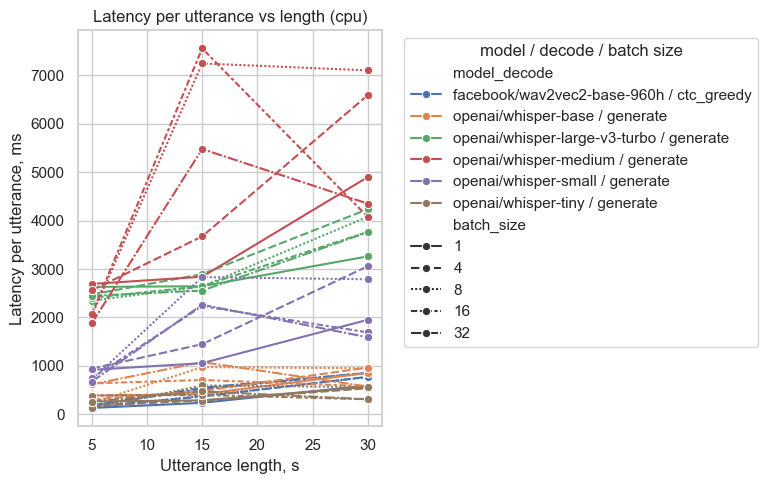

График сохранен по пути: ASR_Experiments/plots/wer_vs_length_cpu.png


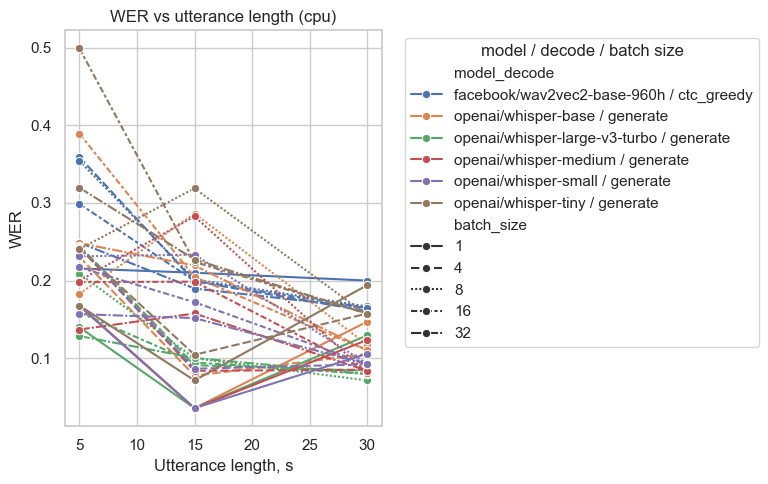

График сохранен по пути: ASR_Experiments/plots/energy_vs_length_cpu.png


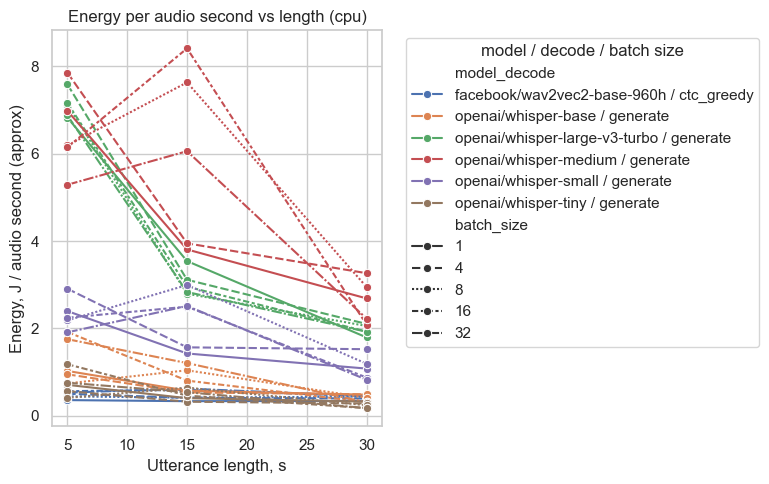

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_cpu_5s.png


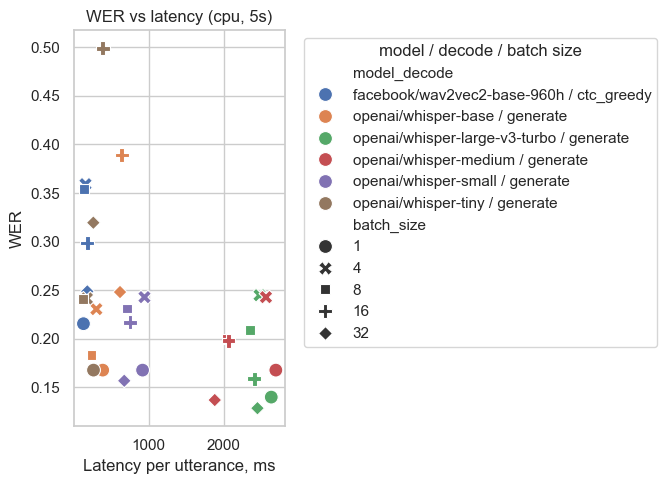

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_cpu_15s.png


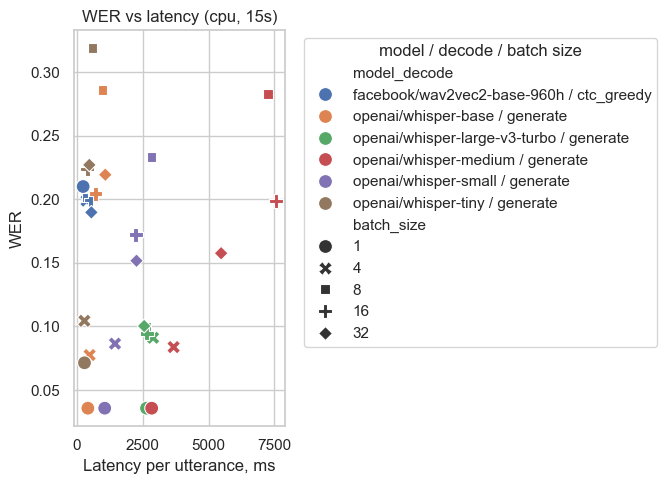

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_cpu_30s.png


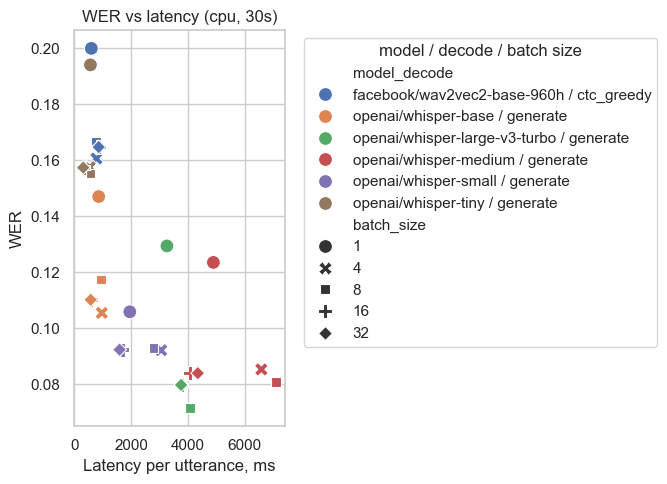

График сохранен по пути: ASR_Experiments/plots/latency_vs_flops_cpu.png


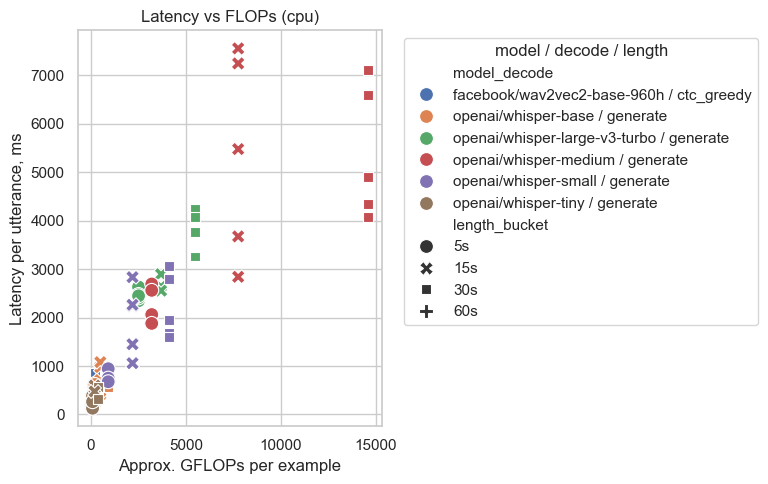

График сохранен по пути: ASR_Experiments/plots/wer_vs_rtf_cpu.png


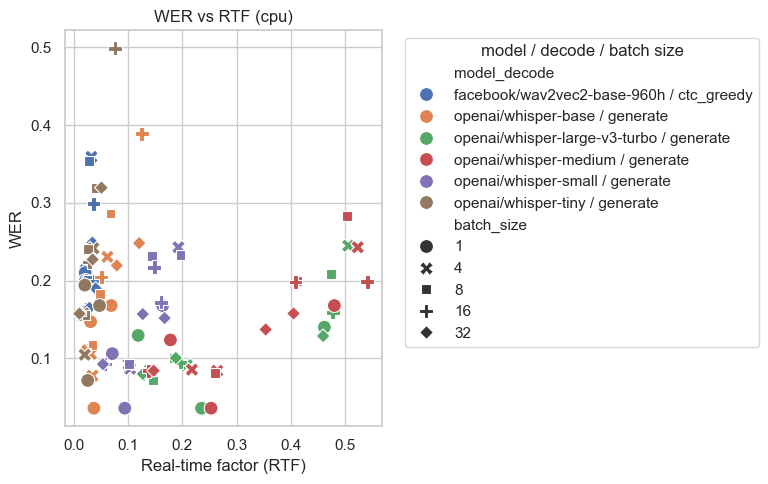

График сохранен по пути: ASR_Experiments/plots/energy_vs_latency_cpu.png


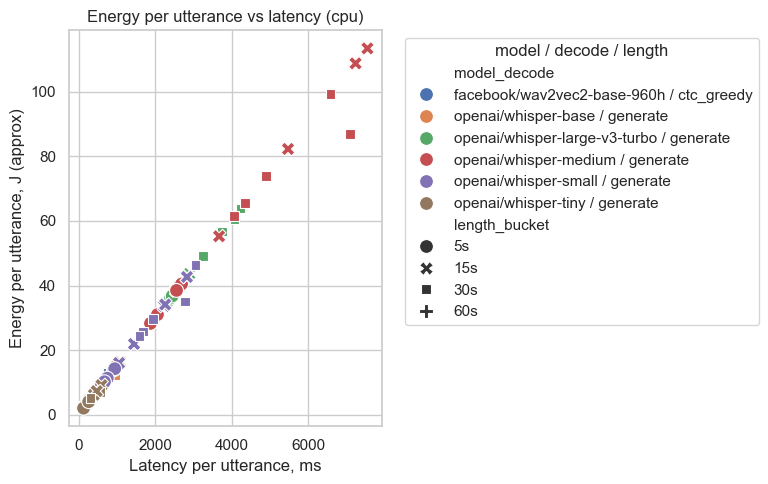

In [29]:
length_order = ["5s", "15s", "30s", "60s"]
df_agg["length_bucket"] = pd.Categorical(
    df_agg["length_bucket"], categories=length_order, ordered=True
)
df_agg = df_agg.sort_values(
    ["device_type", "model_name", "batch_size", "length_bucket"]
)

# 1) Задержка на уттер vs длительность
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=subset,
        x="length_sec",
        y="mean_latency_ms_per_utt",
        hue="model_decode",
        style="batch_size",
        marker="o",
    )
    plt.title(f"Latency per utterance vs length ({device})")
    plt.xlabel("Utterance length, s")
    plt.ylabel("Latency per utterance, ms")
    plt.legend(
        title="model / decode / batch size", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, f"latency_vs_length_{device}")
    plt.show()

# 2) WER vs длительность
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=subset,
        x="length_sec",
        y="mean_wer",
        hue="model_decode",
        style="batch_size",
        marker="o",
    )
    plt.title(f"WER vs utterance length ({device})")
    plt.xlabel("Utterance length, s")
    plt.ylabel("WER")
    plt.legend(
        title="model / decode / batch size", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, f"wer_vs_length_{device}")
    plt.show()

# 3) Энергия на секунду аудио vs длительность
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=subset,
        x="length_sec",
        y="energy_j_per_audio_sec",
        hue="model_decode",
        style="batch_size",
        marker="o",
    )
    plt.title(f"Energy per audio second vs length ({device})")
    plt.xlabel("Utterance length, s")
    plt.ylabel("Energy, J / audio second (approx)")
    plt.legend(
        title="model / decode / batch size", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, f"energy_vs_length_{device}")
    plt.show()

# 4) Trade-off WER vs latency для фиксированных длин
for target_bucket in ["5s", "15s", "30s"]:
    for device in df_agg["device_type"].unique():
        subset = df_agg[
            (df_agg["length_bucket"] == target_bucket)
            & (df_agg["device_type"] == device)
        ]
        if subset.empty:
            continue

        fig = plt.figure(figsize=(7, 5))
        sns.scatterplot(
            data=subset,
            x="mean_latency_ms_per_utt",
            y="mean_wer",
            hue="model_decode",
            style="batch_size",
            s=100,
        )
        plt.title(f"WER vs latency ({device}, {target_bucket})")
        plt.xlabel("Latency per utterance, ms")
        plt.ylabel("WER")
        plt.legend(
            title="model / decode / batch size",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
        plt.tight_layout()
        save_fig(fig, f"wer_vs_latency_{device}_{target_bucket}")
        plt.show()

# 5) FLOPs vs latency
subset_flops = df_agg.dropna(subset=["gflops_per_example"])
if not subset_flops.empty:
    for device in subset_flops["device_type"].unique():
        sdev = subset_flops[subset_flops["device_type"] == device]
        fig = plt.figure(figsize=(8, 5))
        sns.scatterplot(
            data=sdev,
            x="gflops_per_example",
            y="mean_latency_ms_per_utt",
            hue="model_decode",
            style="length_bucket",
            s=100,
        )
        plt.title(f"Latency vs FLOPs ({device})")
        plt.xlabel("Approx. GFLOPs per example")
        plt.ylabel("Latency per utterance, ms")
        plt.legend(
            title="model / decode / length", bbox_to_anchor=(1.05, 1), loc="upper left"
        )
        plt.tight_layout()
        save_fig(fig, f"latency_vs_flops_{device}")
        plt.show()

# 6) Память GPU vs batch size
gpu_only = df_agg[(df_agg["device_type"] == "cuda") & (df_agg["max_gpu_mem_bytes"] > 0)]
if not gpu_only.empty:
    gpu_only = gpu_only.copy()
    gpu_only["max_gpu_mem_gb"] = gpu_only["max_gpu_mem_bytes"] / (1024**3)

    fig = plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=gpu_only,
        x="batch_size",
        y="max_gpu_mem_gb",
        hue="model_decode",
        style="length_bucket",
        marker="o",
    )
    plt.title("GPU memory vs batch size (by length bucket)")
    plt.xlabel("Batch size")
    plt.ylabel("Max GPU memory, GB")
    plt.legend(
        title="model / decode / length", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, "gpu_memory_vs_batch")
    plt.show()

# 7) WER vs RTF
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=subset,
        x="mean_rtf",
        y="mean_wer",
        hue="model_decode",
        style="batch_size",
        s=100,
    )
    plt.title(f"WER vs RTF ({device})")
    plt.xlabel("Real-time factor (RTF)")
    plt.ylabel("WER")
    plt.legend(
        title="model / decode / batch size", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, f"wer_vs_rtf_{device}")
    plt.show()

# 8) Energy per utterance vs latency
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=subset,
        x="mean_latency_ms_per_utt",
        y="energy_j_per_utt",
        hue="model_decode",
        style="length_bucket",
        s=100,
    )
    plt.title(f"Energy per utterance vs latency ({device})")
    plt.xlabel("Latency per utterance, ms")
    plt.ylabel("Energy per utterance, J (approx)")
    plt.legend(
        title="model / decode / length", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    save_fig(fig, f"energy_vs_latency_{device}")
    plt.show()

График сохранен по пути: ASR_Experiments/plots/latency_vs_length_log_cpu.png


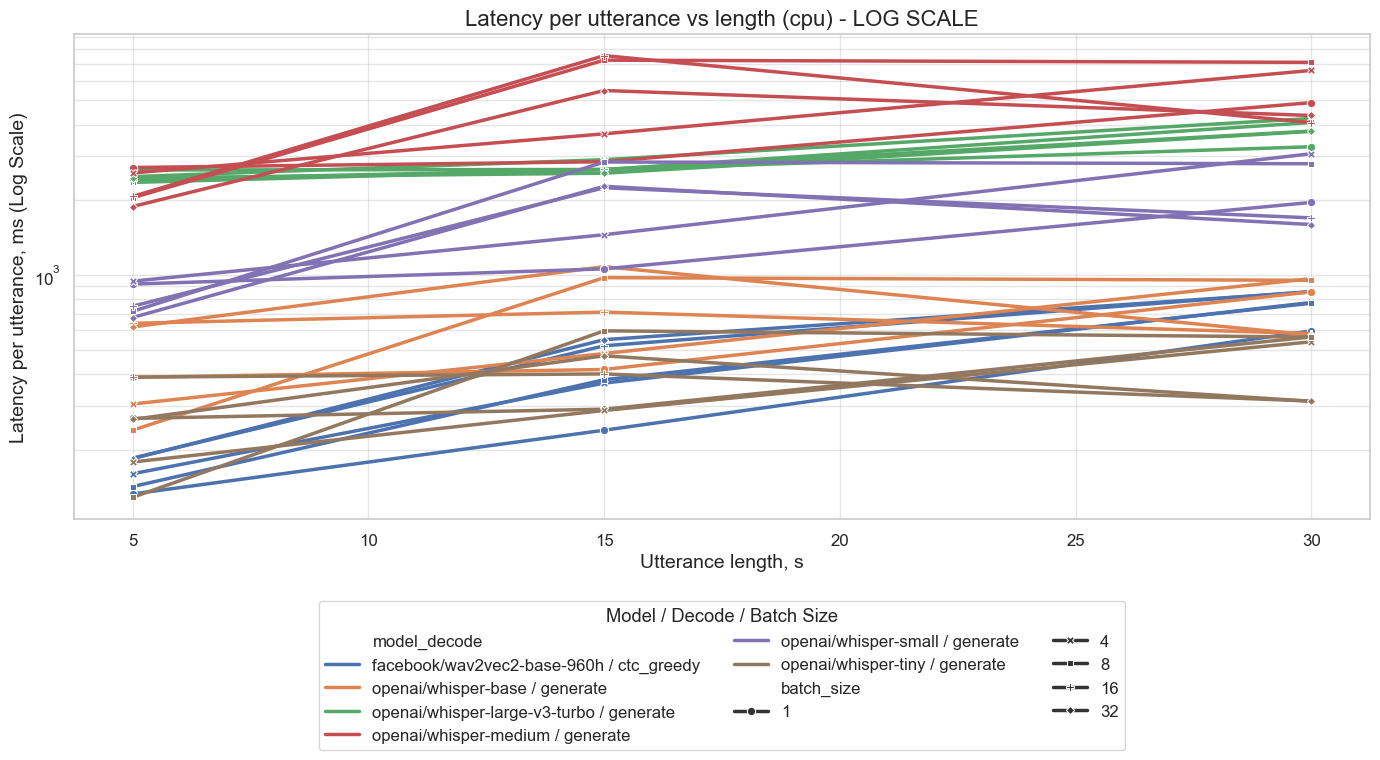

График сохранен по пути: ASR_Experiments/plots/wer_vs_length_pretty_cpu.png


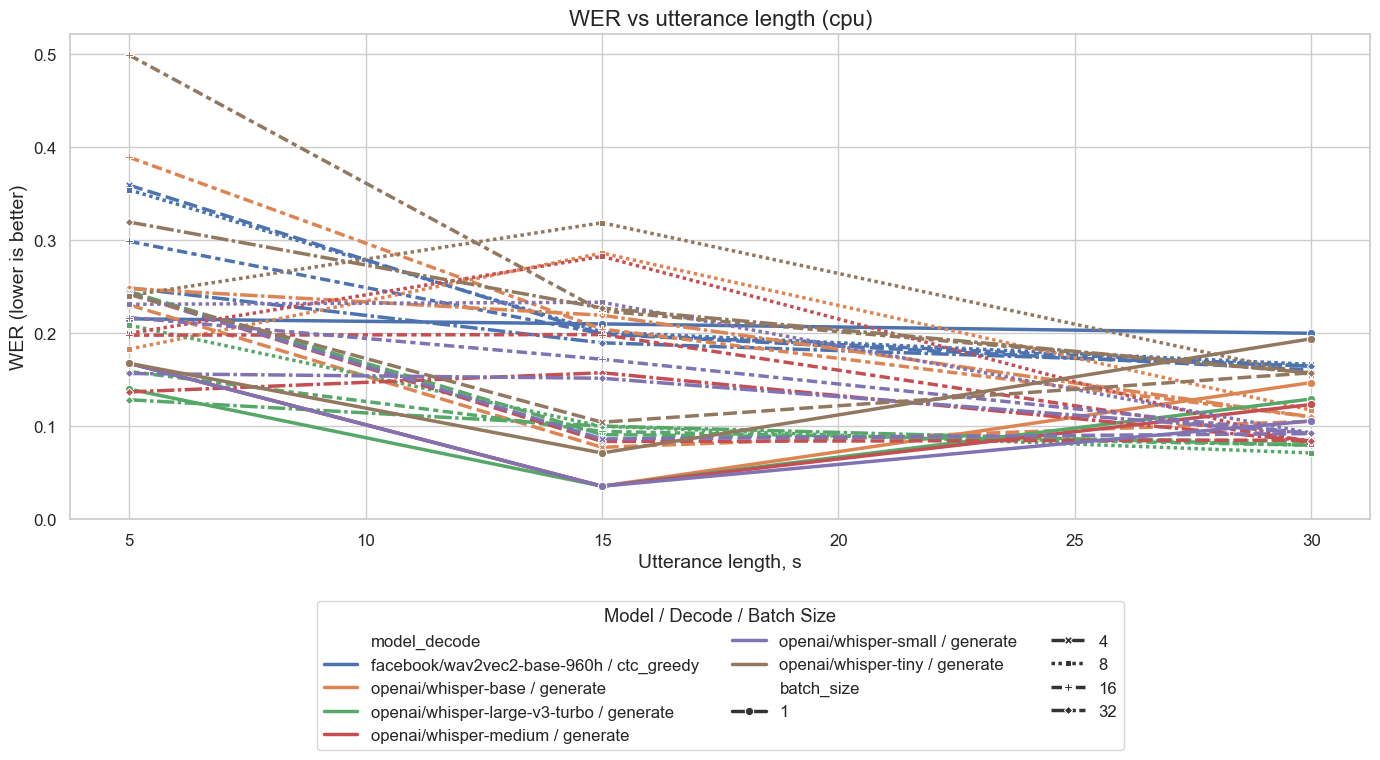

График сохранен по пути: ASR_Experiments/plots/energy_vs_length_pretty_cpu.png


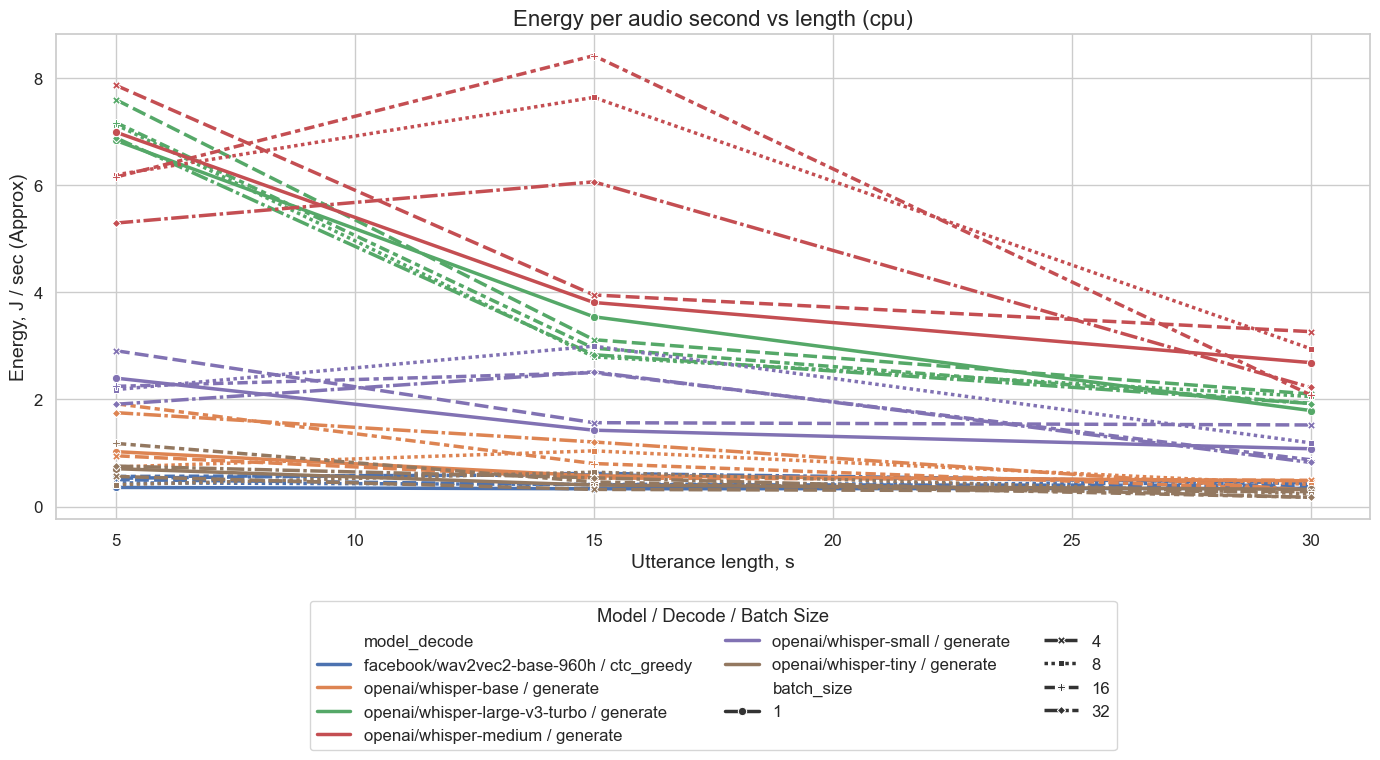

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_pretty_cpu_5s.png


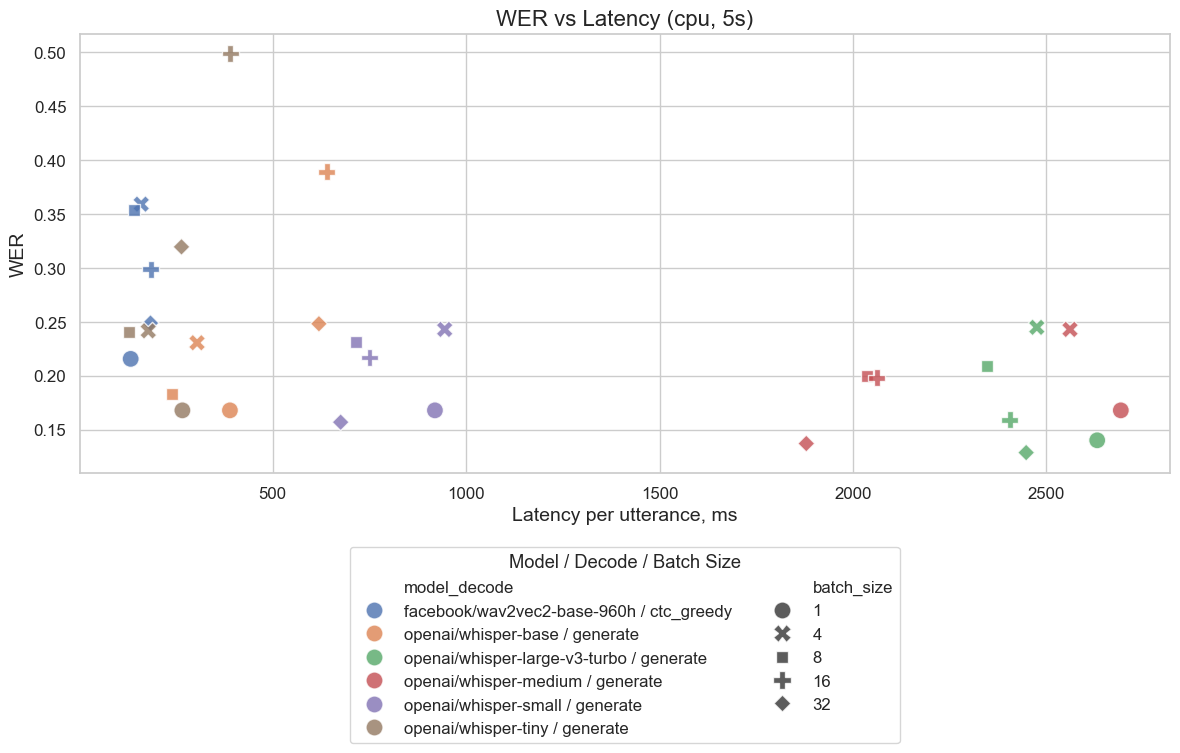

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_pretty_cpu_15s.png


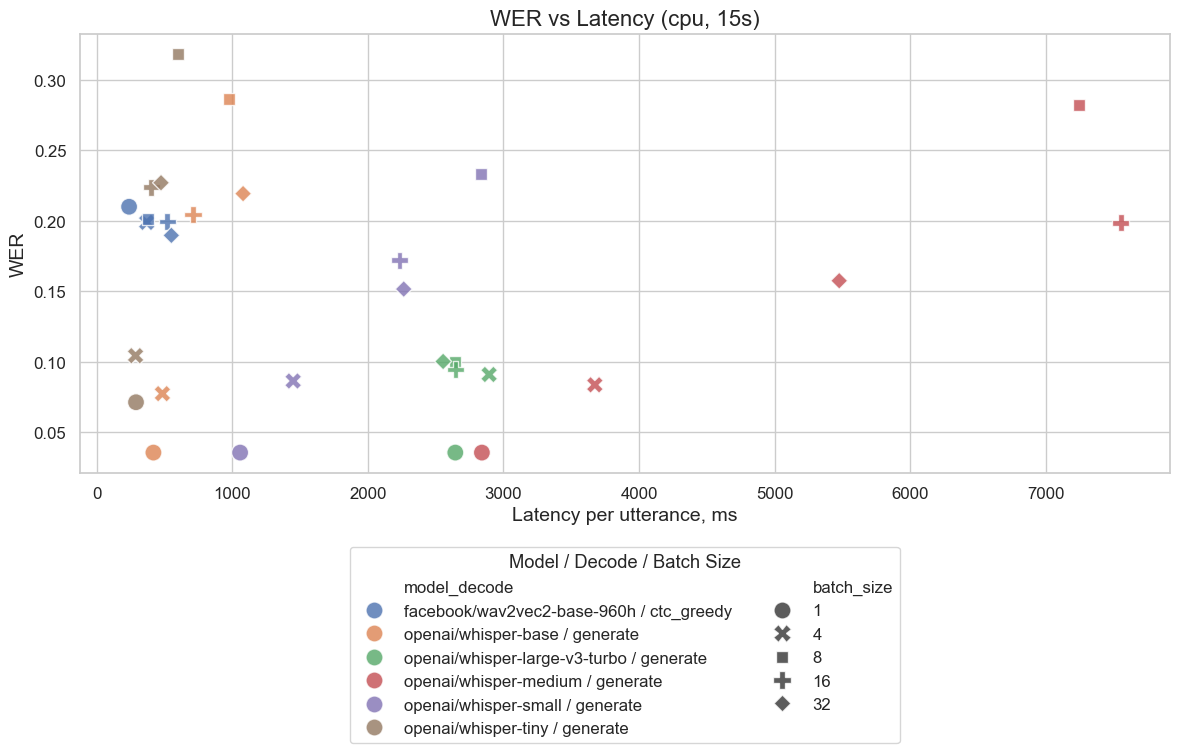

График сохранен по пути: ASR_Experiments/plots/wer_vs_latency_pretty_cpu_30s.png


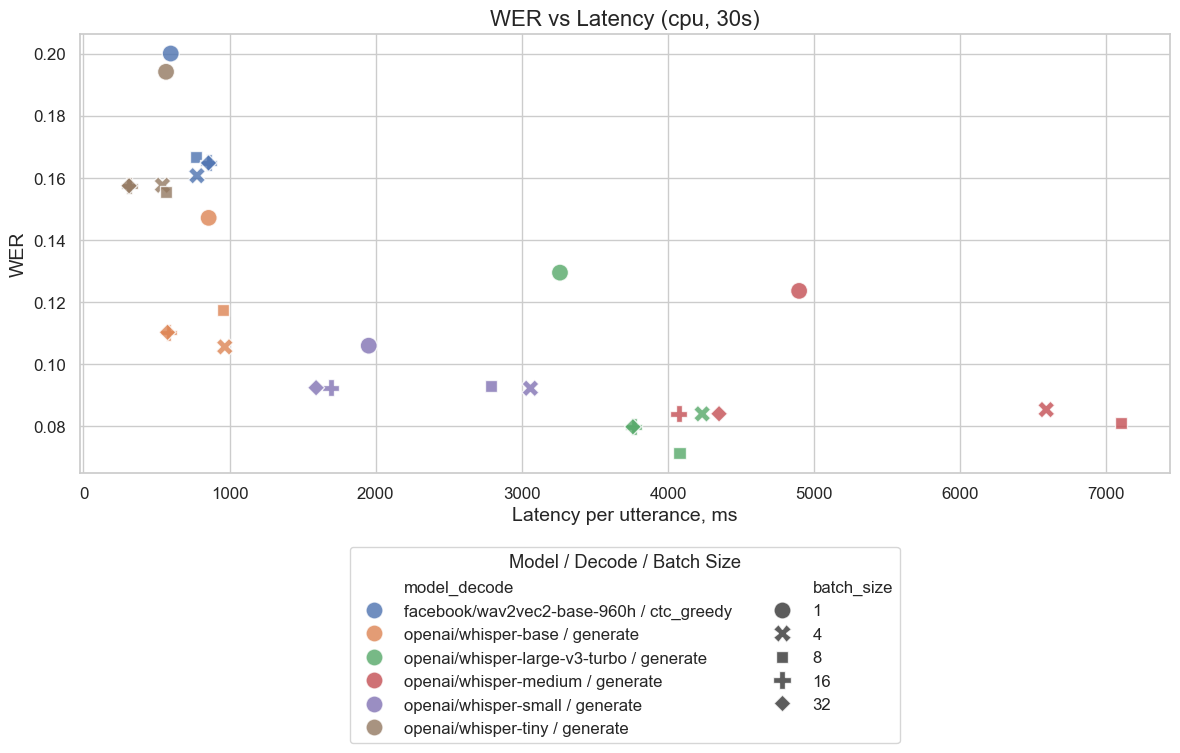

График сохранен по пути: ASR_Experiments/plots/latency_vs_flops_pretty_cpu.png


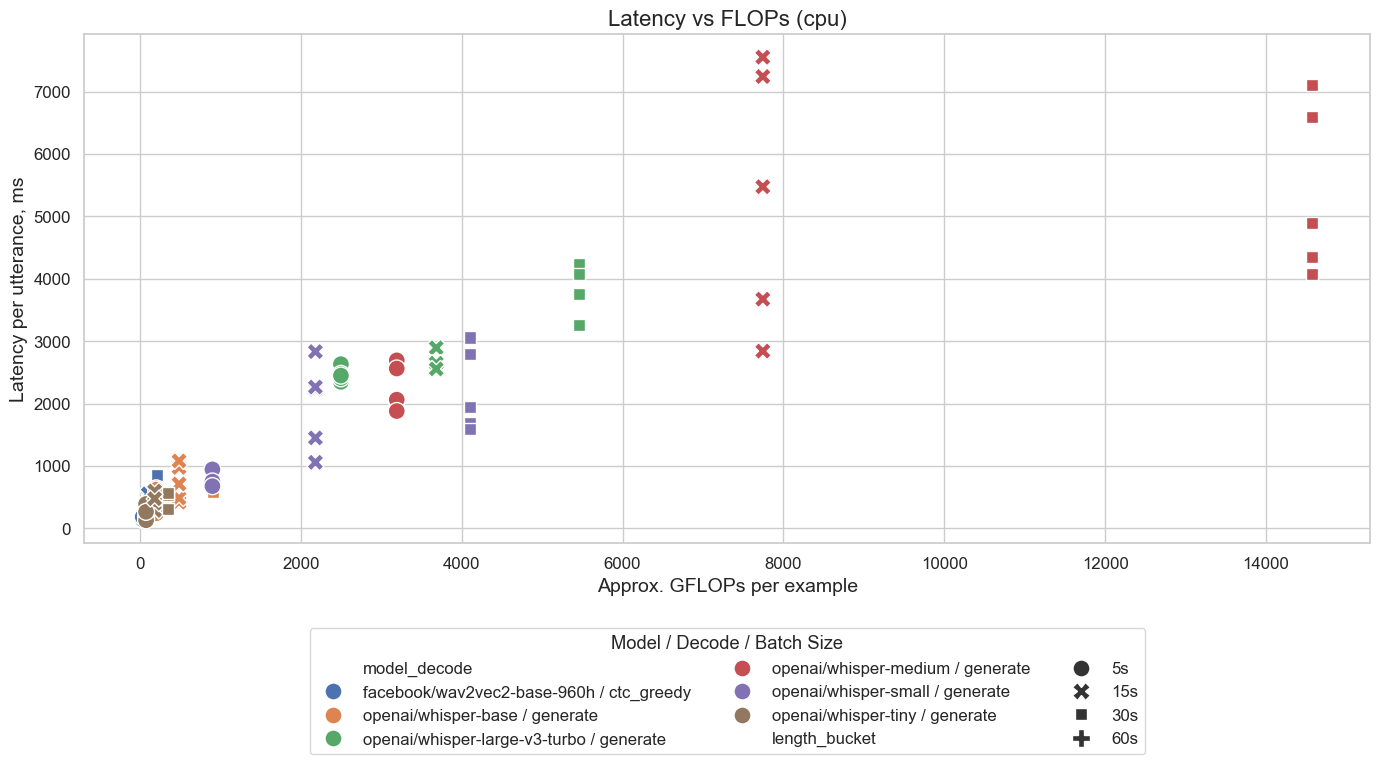

Saved figure to: ASR_Experiments/plots/latency_breakdown_cpu.png


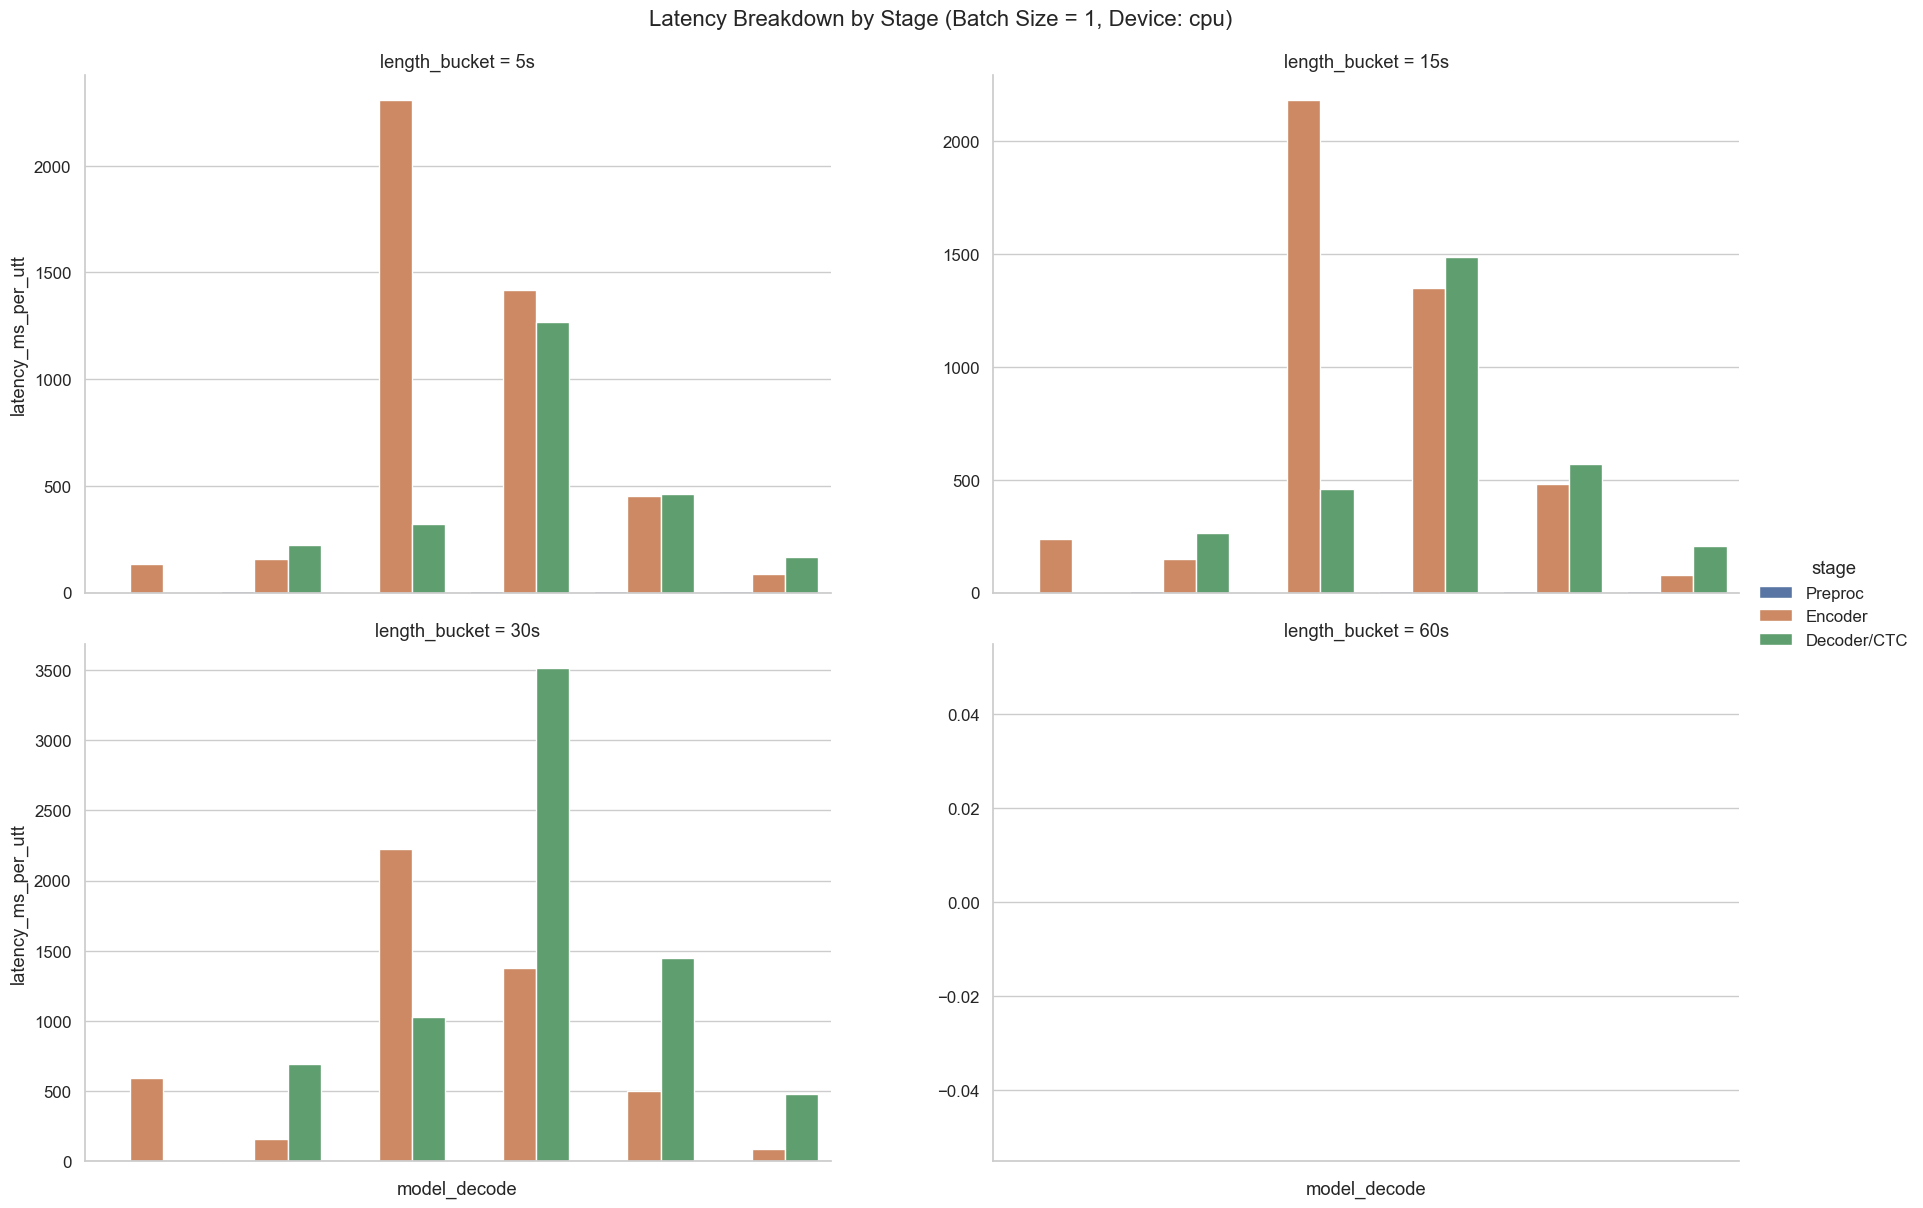

In [30]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("whitegrid")

length_order = ["5s", "15s", "30s", "60s"]
df_agg["length_bucket"] = pd.Categorical(
    df_agg["length_bucket"], categories=length_order, ordered=True
)
df_agg = df_agg.sort_values(
    ["device_type", "model_name", "batch_size", "length_bucket"]
)


def move_legend_to_bottom(ax, ncol=3):
    if ax.get_legend():
        ax.get_legend().remove()
    plt.legend(
        title="Model / Decode / Batch Size",
        bbox_to_anchor=(0.5, -0.15),
        loc="upper center",
        ncol=ncol,
        frameon=True,
    )


# --- 1) Latency vs length (log) ---
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=subset,
        x="length_sec",
        y="mean_latency_ms_per_utt",
        hue="model_decode",
        style="batch_size",
        markers=True,
        dashes=False,
        linewidth=2.5,
    )
    plt.title(f"Latency per utterance vs length ({device}) - LOG SCALE", fontsize=16)
    plt.xlabel("Utterance length, s", fontsize=14)
    plt.ylabel("Latency per utterance, ms (Log Scale)", fontsize=14)
    plt.yscale("log")
    plt.grid(True, which="both", ls="-", alpha=0.5)

    move_legend_to_bottom(ax, ncol=3)
    plt.tight_layout()
    save_fig(fig, f"latency_vs_length_log_{device}")
    plt.show()

# --- 2) WER vs length ---
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=subset,
        x="length_sec",
        y="mean_wer",
        hue="model_decode",
        style="batch_size",
        markers=True,
        linewidth=2.5,
    )
    plt.title(f"WER vs utterance length ({device})", fontsize=16)
    plt.xlabel("Utterance length, s", fontsize=14)
    plt.ylabel("WER (lower is better)", fontsize=14)
    plt.ylim(bottom=0)

    move_legend_to_bottom(ax, ncol=3)
    plt.tight_layout()
    save_fig(fig, f"wer_vs_length_pretty_{device}")
    plt.show()

# --- 3) Energy vs length ---
for device in df_agg["device_type"].unique():
    subset = df_agg[df_agg["device_type"] == device]
    fig = plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=subset,
        x="length_sec",
        y="energy_j_per_audio_sec",
        hue="model_decode",
        style="batch_size",
        markers=True,
        linewidth=2.5,
    )
    plt.title(f"Energy per audio second vs length ({device})", fontsize=16)
    plt.xlabel("Utterance length, s", fontsize=14)
    plt.ylabel("Energy, J / sec (Approx)", fontsize=14)

    move_legend_to_bottom(ax, ncol=3)
    plt.tight_layout()
    save_fig(fig, f"energy_vs_length_pretty_{device}")
    plt.show()

# --- 4) Trade-off WER vs Latency ---
for target_bucket in ["5s", "15s", "30s"]:
    for device in df_agg["device_type"].unique():
        subset = df_agg[
            (df_agg["length_bucket"] == target_bucket)
            & (df_agg["device_type"] == device)
        ]
        if subset.empty:
            continue

        fig = plt.figure(figsize=(12, 8))
        ax = sns.scatterplot(
            data=subset,
            x="mean_latency_ms_per_utt",
            y="mean_wer",
            hue="model_decode",
            style="batch_size",
            s=150,
            alpha=0.8,
        )
        plt.title(f"WER vs Latency ({device}, {target_bucket})", fontsize=16)
        plt.xlabel("Latency per utterance, ms", fontsize=14)
        plt.ylabel("WER", fontsize=14)

        move_legend_to_bottom(ax, ncol=2)
        plt.tight_layout()
        save_fig(fig, f"wer_vs_latency_pretty_{device}_{target_bucket}")
        plt.show()

# --- 5) Latency vs FLOPs ---
subset_flops = df_agg.dropna(subset=["gflops_per_example"])
if not subset_flops.empty:
    for device in subset_flops["device_type"].unique():
        sdev = subset_flops[subset_flops["device_type"] == device]
        fig = plt.figure(figsize=(14, 8))
        ax = sns.scatterplot(
            data=sdev,
            x="gflops_per_example",
            y="mean_latency_ms_per_utt",
            hue="model_decode",
            style="length_bucket",
            s=150,
        )
        plt.title(f"Latency vs FLOPs ({device})", fontsize=16)
        plt.xlabel("Approx. GFLOPs per example", fontsize=14)
        plt.ylabel("Latency per utterance, ms", fontsize=14)

        move_legend_to_bottom(ax, ncol=3)
        plt.tight_layout()
        save_fig(fig, f"latency_vs_flops_pretty_{device}")
        plt.show()

# --- 6) GPU memory vs batch size ---
gpu_only = df_agg[
    (df_agg["device_type"] == "cuda") & (df_agg["max_gpu_mem_bytes"] > 0)
].copy()
if not gpu_only.empty:
    gpu_only["max_gpu_mem_gb"] = gpu_only["max_gpu_mem_bytes"] / (1024**3)

    fig = plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=gpu_only,
        x="batch_size",
        y="max_gpu_mem_gb",
        hue="model_decode",
        style="length_bucket",
        markers=True,
        linewidth=2.5,
    )
    plt.title("GPU memory vs Batch size", fontsize=16)
    plt.xlabel("Batch size", fontsize=14)
    plt.ylabel("Max GPU memory, GB", fontsize=14)
    plt.axhline(y=15.0, color="r", linestyle="--", label="T4 Limit (~15GB)")

    move_legend_to_bottom(ax, ncol=3)
    plt.tight_layout()
    save_fig(fig, "gpu_memory_vs_batch_pretty")
    plt.show()

# --- 7) BREAKDOWN: preproc vs encoder vs decoder ---
stage_cols = ["t_preproc_ms_per_utt", "t_encoder_ms_per_utt", "t_decoder_ms_per_utt"]
if all(c in df_agg.columns for c in stage_cols):
    df_stages = df_agg[df_agg["batch_size"] == 1].copy()
    if not df_stages.empty:
        stage_label_map = {
            "t_preproc_ms_per_utt": "Preproc",
            "t_encoder_ms_per_utt": "Encoder",
            "t_decoder_ms_per_utt": "Decoder/CTC",
        }
        df_melt = df_stages.melt(
            id_vars=["model_name", "model_decode", "device_type", "length_bucket"],
            value_vars=stage_cols,
            var_name="stage",
            value_name="latency_ms_per_utt",
        )
        df_melt["stage"] = df_melt["stage"].map(stage_label_map)

        for device in df_melt["device_type"].unique():
            subset = df_melt[df_melt["device_type"] == device]

            g = sns.catplot(
                data=subset,
                kind="bar",
                x="model_decode",
                y="latency_ms_per_utt",
                hue="stage",
                col="length_bucket",
                col_wrap=2,
                height=6,
                aspect=1.5,
                sharey=False,
            )
            g.fig.suptitle(
                f"Latency Breakdown by Stage (Batch Size = 1, Device: {device})",
                y=1.02,
                fontsize=16,
            )
            g.set_xticklabels(rotation=45, ha="right")

            out_path = PLOTS_DIR / f"latency_breakdown_{device}.png"
            g.fig.savefig(out_path, dpi=200, bbox_inches="tight")
            print(f"Saved figure to: {out_path}")

            plt.show()